In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [25]:
import sys

from typing import Dict, Optional, Tuple
from pathlib import Path

import math

import tensorflow as tf
from tensorflow import keras

import seaborn as sns
import matplotlib.pyplot as plt

from tensorflow.keras.preprocessing.image import ImageDataGenerator

from sklearn import preprocessing
from sklearn.model_selection import train_test_split

from tensorflow.keras import backend #Keras version 2.1.6
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, Concatenate, LeakyReLU, Input, Conv2D, MaxPooling2D 

from tensorflow.keras import layers

from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.preprocessing import image
#from PIL import Image

from sklearn.metrics import r2_score
from sklearn.utils import shuffle

%matplotlib inline

In [26]:
df = pd.read_csv('kaggle/input/Air Pollution Image Dataset/Air Pollution Image Dataset/Combined_Dataset/IND_and_Nep_AQI_Dataset.csv')
df.head()

,Location,Filename,Year,Month,Day,Hour,AQI,PM2.5,PM10,O3,CO,SO2,NO2,AQI_Class
0,"Biratnagar, Nepal",BRI_Un_2023-02-02- 12.00-9.jpg,2023,2,2,12:00,158,70.08,100.82,58.89,0.49,4.4,1.04,d_Unhealthy
1,"Biratnagar, Nepal",BRI_Un_2023-02-02- 12.00-8.jpg,2023,2,2,12:00,158,70.08,100.82,58.89,0.49,4.4,1.04,d_Unhealthy
2,"Biratnagar, Nepal",BRI_Un_2023-02-02- 12.00-7.jpg,2023,2,2,12:00,158,70.08,100.82,58.89,0.49,4.4,1.04,d_Unhealthy
3,"Biratnagar, Nepal",BRI_Un_2023-02-02- 12.00-6.jpg,2023,2,2,12:00,158,70.08,100.82,58.89,0.49,4.4,1.04,d_Unhealthy
4,"Biratnagar, Nepal",BRI_Un_2023-02-02- 12.00-5.jpg,2023,2,2,12:00,158,70.08,100.82,58.89,0.49,4.4,1.04,d_Unhealthy


In [27]:
df = shuffle(df)

df.sample(frac=1).reset_index(drop=True)

number_of_rows = 3000
sub_dfs = [df[i:i + number_of_rows] for i in range(0, df.shape[0], number_of_rows)]
for idx, sub_df in enumerate(sub_dfs):
    sub_df.to_csv(f'frag3000_{idx}.csv', index=False)

In [28]:
df = pd.read_csv('frag3000_1.csv')
df.head(15)

,Location,Filename,Year,Month,Day,Hour,AQI,PM2.5,PM10,O3,CO,SO2,NO2,AQI_Class
0,"ITO, Delhi",DEL_VUH_2023-02-04-17.00-2-161.jpg,2023,2,4,17:00,281,174.00,132.00,97.00,24.00,19.00,71.00,e_Very_Unhealthy
1,"Biratnagar, Nepal",BIR_UNFSG_VF_2023-02-03-16.00-1-93.jpg,2023,2,3,16:00,141,50.29,72.18,59.66,0.45,2.60,4.19,c_Unhealthy_for_Sensitive_Groups
2,"ITO, Delhi",DEL_SEV_2023-02-20-14.00-3-366.jpg,2023,2,20,14:00,363,257.00,139.00,41.00,65.00,35.00,83.00,f_Severe
3,Bengaluru,BENGR_Good_2023-02-26-08.30-1-251.jpg,2023,2,26,8:30,48,24.00,47.00,17.00,210.00,13.00,14.00,a_Good
4,"Dimapur, Nagaland",Dimapur_MOD_2023-02-10-08.30-1-41.jpg,2023,2,10,8:30,63,31.00,52.00,10.00,6.00,4.00,2.00,b_Moderate
5,"ITO, Delhi",DEL_SEV_2023-02-07-14.00-2-25.jpg,2023,2,7,14:00,449,337.00,198.00,23.00,24.00,13.00,57.00,f_Severe
6,"Biratnagar, Nepal",BIR_UNH_VF_2023-02-02- 1700-3-24.jpg,2023,2,2,17:00,156,67.06,95.93,52.38,0.52,3.35,6.49,d_Unhealthy
7,"Biratnagar, Nepal",BIR_UNH_VF_2023-02-02- 12.00-1-25.jpg,2023,2,2,12:00,158,70.08,100.82,58.89,0.49,4.40,1.04,d_Unhealthy
8,Mumbai,MH_UnFSG_2023-03-10-16.00-1-41.jpg,2023,3,10,16:00,141,72.00,108.00,NaN,NaN,NaN,63.00,c_Unhealthy_for_Sensitive_Groups
9,Mumbai,MH_UnFSG_2023-02-15-10.30-1-42.jpg,2023,2,15,10:00,143,334.00,276.00,14.00,77.00,NaN,160.00,c_Unhealthy_for_Sensitive_Groups


In [ ]:
def build_x(path):
    train_img = []
    for i in range(df.shape[0]):
        img = image.load_img(path + df['Filename'][i])
        img = image.img_to_array(img)
        img = tf.keras.applications.vgg16.preprocess_input(img)
        #img = img / 255        # with respect to imagenet, no scaling be used
        train_img.append(img)

    x = np.array(train_img)
    return x

In [ ]:
x_origin = build_x('kaggle/input/Air Pollution Image Dataset/Air Pollution Image Dataset/Combined_Dataset/All_img/')

In [31]:
x_origin.shape

(3000, 224, 224, 3)

In [32]:
pm10 =pd.DataFrame(df['PM10'])
pm10

,PM10
0,132.00
1,72.18
2,139.00
3,47.00
4,52.00
...,...
2995,201.00
2996,180.00
2997,68.92
2998,139.00


In [33]:
x_origin_train, x_origin_temp, y_train, y_temp = train_test_split(x_origin, pm10, train_size=0.8, shuffle=True)

In [34]:
x_origin_valid, x_origin_test, y_valid, y_test = train_test_split(x_origin_temp, y_temp, test_size=0.5, shuffle=True)

In [35]:
x_origin_train.shape

(2400, 224, 224, 3)

In [36]:
y_train.shape

(2400, 1)

In [37]:
x_origin = []
x_origin_temp = []
y_temp = []
y = []

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.47717646..0.5492588].


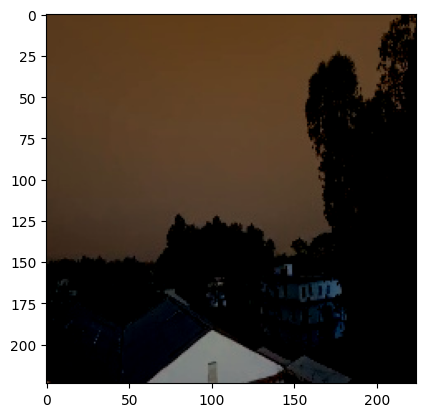

In [38]:
plt.imshow(x_origin_test[10]/255)

In [39]:
y_test = y_test.reset_index(drop=True)
y_test

,PM10
0,72.18
1,352.00
2,36.00
3,169.00
4,480.00
...,...
295,90.80
296,182.00
297,272.00
298,180.00


In [40]:
y_test.head(15)

,PM10
0,72.18
1,352.00
2,36.00
3,169.00
4,480.00
5,169.00
6,177.00
7,272.00
8,84.00
9,95.93


In [41]:
pre_trained_model  = tf.keras.applications.VGG16(input_shape=(224, 224, 3), include_top=False, weights="imagenet")
for layer in pre_trained_model.layers:
    layer.trainable = False
    print(layer.name)


input_layer_1
block1_conv1
block1_conv2
block1_pool
block2_conv1
block2_conv2
block2_pool
block3_conv1
block3_conv2
block3_conv3
block3_pool
block4_conv1
block4_conv2
block4_conv3
block4_pool
block5_conv1
block5_conv2
block5_conv3
block5_pool


In [43]:
x1 = Flatten()(pre_trained_model.output)
fc1 = Dense(512, activation = 'relu')(x1)
fc2 = Dense(512, activation = 'relu')(fc1)
x = Dense(1, activation='linear')(fc2)
model = Model(pre_trained_model.input, x)

opt = tf.keras.optimizers.Adam(learning_rate=0.0001)
model.compile(loss='mse', optimizer=opt)
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 512)            │    12,845,568 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 512)            │       262,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │           513 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 27,823,425 (106.14 MB)

 Trainable params: 13,108,737 (50.01 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

In [46]:
# Change your filepath to end with .weights.h5
weight_path = 'vgg16_aqi.best.weights.h5'

callback = [
    EarlyStopping(monitor='val_loss', patience=15, verbose=1, mode='auto'),
    ModelCheckpoint(weight_path, monitor='val_loss', verbose=1, 
                   save_best_only=True, mode='min', save_weights_only=True)]

In [47]:
callback = [
    EarlyStopping(monitor='val_loss', patience=15, verbose=1, mode='auto'),
    ModelCheckpoint(weight_path, monitor='val_loss', verbose=1, 
                    save_best_only=True, mode='min', save_weights_only = True)]
history = model.fit(x=x_origin_train, y=y_train, validation_data=(x_origin_valid, y_valid), batch_size=16, epochs=150, callbacks=callback)

2025-02-12 12:34:33.034109: W external/local_xla/xla/tsl/framework/bfc_allocator.cc:497] Allocator (GPU_0_bfc) ran out of memory trying to allocate 1.35GiB (rounded to 1445068800)requested by op _EagerConst
If the cause is memory fragmentation maybe the environment variable 'TF_GPU_ALLOCATOR=cuda_malloc_async' will improve the situation. 
Current allocation summary follows.
Current allocation summary follows.
2025-02-12 12:34:33.034204: I external/local_xla/xla/tsl/framework/bfc_allocator.cc:1053] BFCAllocator dump for GPU_0_bfc
2025-02-12 12:34:33.034233: I external/local_xla/xla/tsl/framework/bfc_allocator.cc:1060] Bin (256): 	Total Chunks: 37, Chunks in use: 37. 9.2KiB allocated for chunks. 9.2KiB in use in bin. 1.1KiB client-requested in use in bin.
2025-02-12 12:34:33.034248: I external/local_xla/xla/tsl/framework/bfc_allocator.cc:1060] Bin (512): 	Total Chunks: 4, Chunks in use: 4. 2.0KiB allocated for chunks. 2.0KiB in use in bin. 2.0KiB client-requested in use in bin.
2025-02-1

InternalError: Failed copying input tensor from /job:localhost/replica:0/task:0/device:CPU:0 to /job:localhost/replica:0/task:0/device:GPU:0 in order to run _EagerConst: Dst tensor is not initialized.

In [ ]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [ ]:
model.load_weights(weight_path)

In [ ]:
loss = model.evaluate(x=x_origin_test, y=y_test, batch_size=16)
print('RMSE is :', loss ** 0.5)

In [ ]:
y_predict = model.predict(x_origin_test)

In [ ]:
from sklearn.metrics import r2_score

r2_score(y_test, y_predict)

In [ ]:
y_predict_pm10 = np.zeros(len(y_predict))

for i in range(len(y_predict)):
    if y_predict[i] <= 54:
        y_predict_pm10[i] = 0
    elif y_predict[i] >= 55 and y_predict[i] <= 154:
        y_predict_pm10[i] = 1
    elif y_predict[i] >= 155 and y_predict[i] <= 254:
        y_predict_pm10[i] = 2
    elif y_predict[i] >= 255 and y_predict[i] <= 354:
        y_predict_pm10[i] = 3
    elif y_predict[i] >= 355 and y_predict[i] <= 424:
        y_predict_pm10[i] = 4
    elif y_predict[i] > 424:
        y_predict_pm10[i] = 5
    else:
        print('Exception Occured!')
    
y_predict_pm10 = y_predict_pm10.astype(int)
    
    
y_predict_pm10

In [ ]:
y_test = y_test.to_numpy().tolist()
y_test

In [ ]:
y_test[1][0]

In [ ]:
#Classify the Ground Truth PM10 concentration to the air quality levels

y_test_pm10 = np.zeros(len(y_test))

for i in range(len(y_test)):
    if int(y_test[i][0])  <= 54:
        y_test_pm10[i] = 0
    elif int(y_test[i][0]) >= 55 and int(y_test[i][0]) <= 154:
        y_test_pm10[i] = 1
    elif int(y_test[i][0]) >= 155 and int(y_test[i][0]) <= 254:
        y_test_pm10[i] = 2
    elif int(y_test[i][0]) >= 255 and int(y_test[i][0]) <= 354:
        y_test_pm10[i] = 3
    elif int(y_test[i][0]) >= 355 and int(y_test[i][0]) <= 424:
        y_test_pm10[i] = 4
    elif int(y_test[i][0]) > 424:
        y_test_pm10[i] = 5
    else:
        print('Exception Occured!')

y_test_pm10 = y_test_pm10.astype(int)
        
        
y_test_pm10

In [ ]:
from sklearn.metrics import balanced_accuracy_score

balanced_accuracy_score(y_test_pm10, y_predict_pm10)

In [ ]:
#---Classification Accuracy for PM2.5---------

t = 0
n = 0

for i in range(len(y_predict_pm10)):
    if y_predict_pm10[i] == y_test_pm10[i]:
        t = t + 1
    else:
        n = n + 1
        
acc = t / len(y_predict_pm10)

print('Acc: ', acc, ' True: ', t, ' False: ', n)

In [ ]:
from sklearn.metrics import f1_score

f1_score(y_test_pm10, y_predict_pm10, average='macro')

In [ ]:
import seaborn as sns
from sklearn.metrics import confusion_matrix
Y_pred_classes = y_predict_pm10
Y_true = y_test_pm10
confusion_mtx = confusion_matrix(Y_true, Y_pred_classes)
f,ax = plt.subplots(figsize=(8, 8))
sns.heatmap(confusion_mtx, annot=True, linewidths=0.01,cmap="Greens",linecolor="gray", fmt= '.1f',ax=ax)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

In [ ]:
plt.plot(y_test, label='True Label')
plt.plot(y_predict, label='Estimation Value')

# set the x-axis label
plt.xlabel('Index')

# set the y-axis label
plt.ylabel('Value')

# set the plot title
plt.title('True vs Estimation')

# Adding a legend
plt.legend()

# display the plot
plt.show()